<a href="https://colab.research.google.com/github/seoyeon0905/mimic-readmission-analysis/blob/main/notebooks/03_readmission_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# colab session setup
%cd /content
!rm -rf mimic-readmission-analysis
!git clone https://github.com/seoyeon0905/mimic-readmission-analysis.git
%cd mimic-readmission-analysis

/content
Cloning into 'mimic-readmission-analysis'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 176 (delta 12), reused 5 (delta 5), pack-reused 155 (from 1)
Receiving objects: 100% (176/176), 386.74 KiB | 4.44 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/mimic-readmission-analysis


In [3]:
# 라이브러리
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [4]:
# 작업위치(폴더)를 notebooks로 변경하기
# 그 작업위치(폴더)에 어떤 파일이 있는지 확인하기
%cd notebooks
!ls

/content/mimic-readmission-analysis/notebooks
01_data_loading.ipynb  02_cohort_definition.ipynb  03_readmission_eda.ipynb


In [5]:
# 데이터 불러오기
df = pd.read_csv("../data/processed/first_icu_admissions.csv")

# 데이터가 제대로 로드됐는지 확인
# 데이터 크기 & 구조 확인

In [6]:
df.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,hospital_expire_flag,has_chartevents_data,admission_order,next_admittime,days_to_next_admit,readmitted_30d,gender,dob,age,icu_los
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,0,1,1,NaN,NaN,0,F,2094-03-05,70,1.632546
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,...,1,1,1,NaN,NaN,0,F,2090-06-05,36,13.850694
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,1,1,NaN,NaN,0,F,2038-09-03,87,2.649907
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,0,1,1,NaN,NaN,0,F,2075-09-21,74,2.143611
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,1,1,1,NaN,NaN,0,M,2114-06-20,49,1.293843


In [7]:
df.shape

(100, 27)

In [8]:
df.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'admission_order',
       'next_admittime', 'days_to_next_admit', 'readmitted_30d', 'gender',
       'dob', 'age', 'icu_los'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row_id                100 non-null    int64  
 1   subject_id            100 non-null    int64  
 2   hadm_id               100 non-null    int64  
 3   admittime             100 non-null    object 
 4   dischtime             100 non-null    object 
 5   deathtime             33 non-null     object 
 6   admission_type        100 non-null    object 
 7   admission_location    100 non-null    object 
 8   discharge_location    100 non-null    object 
 9   insurance             100 non-null    object 
 10  language              57 non-null     object 
 11  religion              99 non-null     object 
 12  marital_status        85 non-null     object 
 13  ethnicity             100 non-null    object 
 14  edregtime             65 non-null     object 
 15  edouttime             65

# Outcome 분포 확인(가장 중요!!)

In [10]:
df['readmitted_30d'].value_counts()

,count
readmitted_30d,
0,92
1,8


In [11]:
df['readmitted_30d'].value_counts(normalize=True)
# 이건 불균형 문제
# 즉, accuracy하나로 모델 평가하면 위험
# baseline부터 신중해야함

# 모든 환자를 "재입원 안함(0)"이라고 예측해도 정확도는 92%
# navie baseline
# 모델 accuracy가 92%가 나왔다는 것 -> 아무 의미 없음

# 이 분포를 보고나면 Accuracy는 적합한 지표가 아니라는 것을 알 수 있음
# 적합한 지표 = Precision, Recall(Sensitivity), AUROC, PR-AUC

# 본 코호트에서 30일 이내 재입원률은 약 8%로 관찰되었으며
# 이는 임상적으로 드문 사건(rare event)에 해

,proportion
readmitted_30d,
0,0.92
1,0.08


# 라벨 sanity check(02_cohort_definition에서 한 것 검증)

In [12]:
df['days_to_next_admit'].describe()

,days_to_next_admit
count,14.000000
mean,45.357143
std,56.165425
min,1.000000
25%,9.500000
50%,20.000000
75%,59.000000
max,182.000000


In [13]:
df[df['readmitted_30d'] == 1]['days_to_next_admit'].max()
# 정상 기준 -> max 값이 30이하
# 라벨 정의가 의도대로 동작하는지 검증

# 30일 재입원으로 라벨링된 샘플들의 입원 간격을 확인한 결과
# 모든 사례가 30일 이내에 포함되어 있어
# 라벨 정의가 의도대로 동작함을 확인했다

23.0

# Baseline demographic 분포

## Age 분포

In [14]:
df['age'].describe()
# max=300 -> 데이터 오류가 아니라 MIMIC의 의도적 처리
# 89세 초과 환자 -> age를 300으로 치환
# 개인정보 보호 목적

# age = 300 -> 89세 이상 고령자
# 이상치처럼 보이지만 사실은 고령자 그룹 표시 값
# In MIMIC-III, ages above 89 are capped at 300 for de-identification purposes.

,age
count,100.000000
mean,88.400000
std,64.836858
min,17.000000
25%,64.750000
50%,76.500000
75%,86.000000
max,300.000000


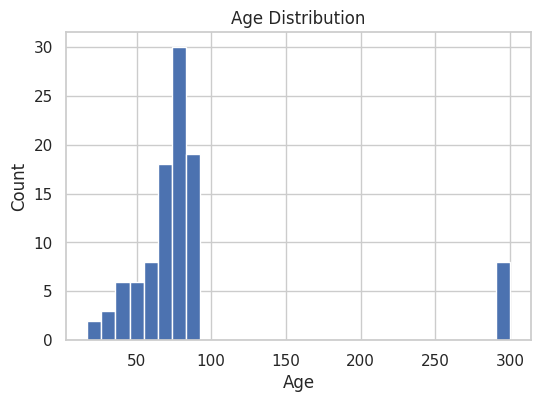

In [15]:
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()
# cohort의 연령대 파악
# 극단값 있는지 확인

## Gender 분포

In [16]:
df['gender'].value_counts()
# 거의 5:5
# 특정 성별 쏠림 없음
# cohort bias 없음
# 성별 분포는 비교적 균형을 이루고 있다

,count
gender,
F,55
M,45


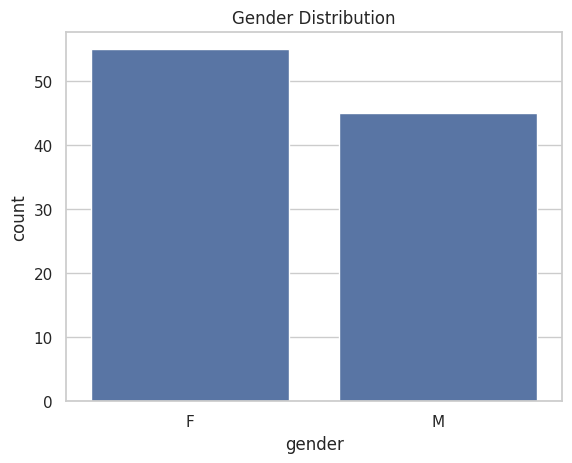

In [17]:
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()
# 성별 불균형 여부 확인
# study population 특성 설명용

## ICU Length of Stay 분포

In [18]:
df['icu_los'].describe()
# 대부분: 짧은 ICU stay
# 소수: 아주 긴 stay
# 전형적인 right-skewed 분포

# 박스플롯 쓸 이유 충분
# 나중에 long-transform 고민할 근거 충분
# 재입원과 연관성 탐색할 가치 충분

,icu_los
count,100.000000
mean,4.771405
std,6.776915
min,0.105926
25%,1.230729
50%,2.259190
75%,4.618220
max,35.406516


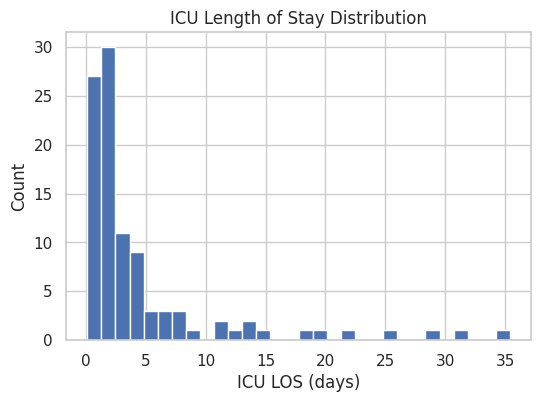

In [19]:
plt.figure(figsize=(6,4))
plt.hist(df['icu_los'], bins=30)
plt.xlabel("ICU LOS (days)")
plt.ylabel("Count")
plt.title("ICU Length of Stay Distribution")
plt.show()
# 오른쪽으로 치우쳐 있나?
# 나중에 로그 변환 필요해 보이나?

In [ ]:
# ICU LOS는 오른쪽으로 치우친 분포를 보여
# 모델링 단계에서 로그 변환 또는 robust한 접근이 필요할 수 있다.

# Outcome별 비교(EDA의 핵심!)

## Gender vs Readmission

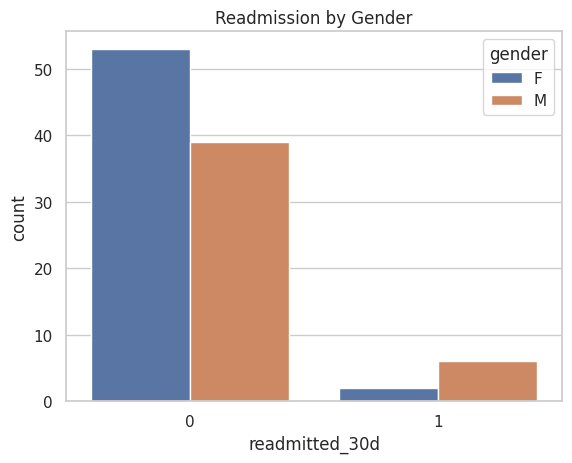

In [23]:
# Gender은 해도되고 안해도됨 -> 있어도 좋고 없어도 전혀 문제 없음
sns.countplot(
    x='readmitted_30d',
    hue='gender',
    data=df
)
plt.title("Readmission by Gender")
plt.show()

## ICU LOS vs Readmission

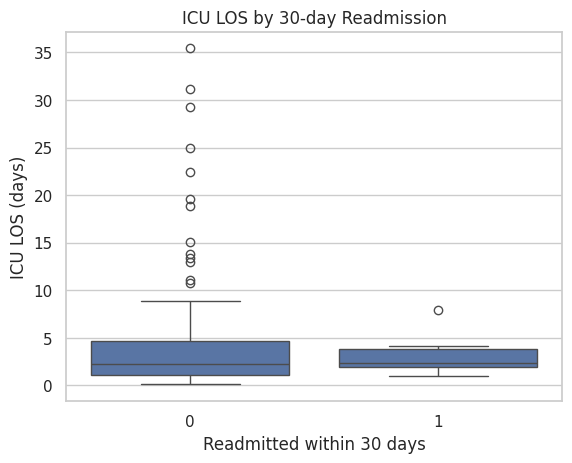

In [20]:
sns.boxplot(
    x='readmitted_30d',
    y='icu_los',
    data=df
)
plt.xlabel("Readmitted within 30 days")
plt.ylabel("ICU LOS (days)")
plt.title("ICU LOS by 30-day Readmission")
plt.show()
# 재입원군에서 ICU LOS가 더 긴 경향이 있는가?

In [ ]:
# 재입원군(1): 중앙값이 약간 더 높음, 분포가 상대적으로 위쪽
# 비재입원군(0): 극단적인 long LOS oulier가 많음

# 재입원군은 전반적으로 ICU LOS가 약간 더 긴 경향을 보이지만
# 비재입원군에도 매우 긴 ICU stay 환자들이 존재한다

# ICU에 오래 있었다고 해서 반드시 재입원X
# ICU LOS는 필요조건도, 충분조건도 아님
# 다만 확률을 높이는 요인 중 하나
# 그래서 모델링 가치 있음

## Age vs Readmission

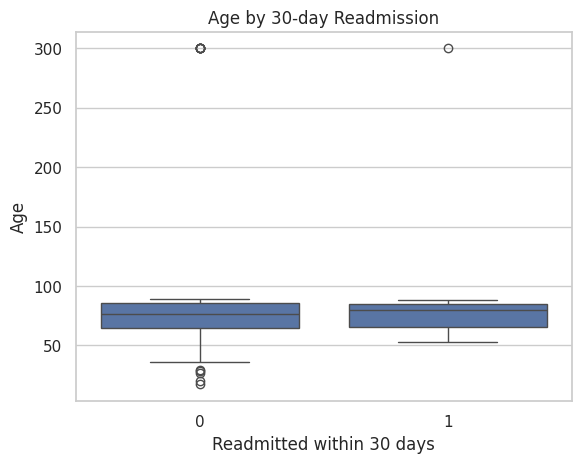

In [21]:
sns.boxplot(
    x='readmitted_30d',
    y='age',
    data=df
)
plt.xlabel("Readmitted within 30 days")
plt.ylabel("Age")
plt.title("Age by 30-day Readmission")
plt.show()
# 연령 차이가 있는지 / 없는

In [ ]:
# 두 그룹의 median 거의 비슷
# 분포도 거의 겹침
# age=300(89+) outlier는 양쪽 다 존재

# 연령 단독으로는 30일 재입원을 명확히 구분하기 어렵다

# age가 강한 predictor였다면
# -> ICU readmission 문제는 너무 쉬운 문제가 됨
# 현실에서는 age는 보정 변수 역할을 함

In [ ]:
# ICU LOS 변수는 outcome과 약한 양의 신호가 있음
# Age 변수는 outcome과 관계가 거의 없음

# 단일 변수로는 재입원을 완벽히 설명할 수 없고
# 여러 변수를 결합한 모델이 필요하다

# 모델링을 해야 할 이유가 생김
# EDA가 모델링으로 자연스럽게 이어

# 간단한 요약 테이블(보고서용)
논문 스타일 좋아하면 해도 되고 개인 프로젝트면 생략해도

In [22]:
df.groupby('readmitted_30d')[['age', 'icu_los']].agg(
    ['mean', 'median', 'std']
)

age                     icu_los                    
                      mean median        std      mean    median       std
readmitted_30d                                                            
0                87.304348   76.0  63.623677  4.913418  2.259190  7.024265
1               101.000000   79.5  81.444109  3.138245  2.377263  2.189946

EDA를 통해 데이터와 라벨의 신뢰성을 확인하고 재입원 예측이 단일 변수로는 어렵다는 점을 확인하였다.

본 탐색적 분석에서는 ICU 환자의 기본 인구학적 및 임상적 특성과 30일 이내 재입원과의 관계를 살펴보았다.
재입원 환자군에서 ICU 재원 기간의 중앙값이 다소 높게 나타났으나
두 집단 간 분포가 상당 부분 겹쳐 단일 변수로서의 구분력은 제한적인 것으로 보인다.
또한 연령 분포는 재입원 여부에 따라 큰 차이를 보이지 않아 연령 단독으로는 30일 재입원을 설명하는 데 한계가 있음을 시사한다.